# Branches

In [1]:
# include common code and config
# selected_pi = 12
%run PIQM_Bootstrap.ipynb

{'pi': 'PI12', 'id': 12, 'start': '2021-09-16T00:00:00Z', 'started': '2021-09-16', 'finish': '2021-12-16T23:59:59Z'}


In [2]:
first_br_trace = """
{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "project_branches")
  |> filter(fn: (r) => r.isstale == "0")
  |> filter(fn: (r) => r.default == "0")  
  |> filter(fn: (r) => r.merged == "1")  
  |> drop(columns:["_measurement", "_field", "isstale", "default", "merged", "mr"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
"""

template_br_trace = """
time1{0[pi]} = uint(v: {0[start]})
time2{0[pi]} = uint(v: {0[current_start]})
dur{0[pi]} = duration(v: time2{0[pi]} - time1{0[pi]})

{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "project_branches")
  |> filter(fn: (r) => r.isstale == "0")
  |> filter(fn: (r) => r.default == "0")  
  |> filter(fn: (r) => r.merged == "1")  
  |> drop(columns:["_measurement", "_field", "isstale", "default", "merged", "mr"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
  |> timeShift(duration: dur{0[pi]}, columns: ["_start", "_stop", "_time"])
"""

# output all the series in reverse order
pis = the_pis.copy()
current = pis.pop(-1)
pi_list = ([current] + pis[: (selected_pi - select_pis) : -1])[::-1]
query = [first_br_trace.format(current)]
tables = ", ".join([pi["pi"] for pi in pi_list])
for pi in pis[: (selected_pi - select_pis) : -1]:
    pi["current_start"] = last_start
    query.append(template_br_trace.format(pi))
query.append("""
union(tables: [{}])
  |> group()
  |> yield(name: "mrs")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()

brs = query_api.query_data_frame(query)
# brs = brs[["_value", "_field"]]\
#     .rename(columns={"_value": "Merge Requests", "_field": "PI"})
brs['ID'] = brs['ID'].astype(int)
brs.sort_values(by=['ID', '_time'], ascending=[True, True], inplace=True)
brs

result table                    _start                     _stop  \
118    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
124    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
135    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
203    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
39     mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
..     ...   ...                       ...                       ...   
212    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
210    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
209    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
109    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
100    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   

                        _time      _value  \
118 2021-09-16 06:42:24+00:00  28925338.0   
124 2021-09-18 08:42:53+00:00  37299392.0   
135 2021-09-21 00:21:02+00:00  37069887.0   
203 2021-10-26 18:13:07+00:00  25427900.0   
39  2021-11-16 22:57:28+00:00  26794461.0   
..                        ...         ...   
212 2021-11-17 10:37:48+00:00    572532.0   
210 2021-11-17 10:41:59+00:00    572310.0   
209 2021-11-17 10:44:06+00:00    572224.0   
109 2021-11-20 01:03:37+00:00    347053.0   
100 2021-11-22 17:27:23+00:00    115253.0   

                               branch_id jira  \
118         fix-problem-integration-ADR8    0   
124                      json_dump_error    0   
135                    metric_management    0   
203                           tango-util    0   
39                                 16bit    0   
..                                   ...  ...   
212                      update-pipeline    0   
210                        update-ci-var    0   
209                        update-ci-var    0   
109                              develop    0   
100  ct-460-specialize-configure-command    1   

                                              project project_id  \
118                             ska-telescope/csp-lmc   15723860   
124                  ska-telescope/web-maxiv-tangogql   15124978   
135  ska-telescope/cbf-sdp-emulator-metrics-generator   19960411   
203                             ska-telescope/csp-lmc   15723860   
39             ska-telescope/sdp/sep_pipeline_imaging   15088717   
..                                                ...        ...   
212                  ska-telescope/web-maxiv-tangogql   15124978   
210                        ska-telescope/webjive-auth   15124933   
209                      ska-telescope/dashboard-repo   15113915   
109     ska-telescope/ska-mid-cbf-engineering-console   29657133   
100                     ska-telescope/ska-csp-lmc-low   25588162   

                                     ref  ID                 PI  
118         fix-problem-integration-ADR8   8   PI8 (2020-09-16)  
124                      json_dump_error   8   PI8 (2020-09-16)  
135                    metric_management   8   PI8 (2020-09-16)  
203                           tango-util   8   PI8 (2020-09-16)  
39                                 16bit   8   PI8 (2020-09-16)  
..                                   ...  ..                ...  
212                      update-pipeline  12  PI12 (2021-09-16)  
210                        update-ci-var  12  PI12 (2021-09-16)  
209                        update-ci-var  12  PI12 (2021-09-16)  
109                              develop  12  PI12 (2021-09-16)  
100  ct-460-specialize-configure-command  12  PI12 (2021-09-16)  

[219 rows x 13 columns]

In [3]:

first_mr_trace = """
{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
"""

template_mr_trace = """
time1{0[pi]} = uint(v: {0[start]})
time2{0[pi]} = uint(v: {0[current_start]})
dur{0[pi]} = duration(v: time2{0[pi]} - time1{0[pi]})

{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
  |> timeShift(duration: dur{0[pi]}, columns: ["_start", "_stop", "_time"])
"""

# output all the series in reverse order
pis = the_pis.copy()
current = pis.pop(-1)
pi_list = ([current] + pis[: (selected_pi - select_pis) : -1])[::-1]
query = [first_mr_trace.format(current)]
tables = ", ".join([pi["pi"] for pi in pi_list])
for pi in pis[: (selected_pi - select_pis) : -1]:
    pi["current_start"] = last_start
    query.append(template_mr_trace.format(pi))
query.append("""
union(tables: [{}])
  |> group()
  |> yield(name: "mrs")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()

mrs = query_api.query_data_frame(query)
# mrs = mrs[["_value", "_field"]]\
#     .rename(columns={"_value": "Merge Requests", "_field": "PI"})
mrs['ID'] = mrs['ID'].astype(int)
mrs.sort_values(by=['ID', '_time'], ascending=[True, True], inplace=True)
mrs

result table                    _start                     _stop  \
1000    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
1083    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
1231    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
1268    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
1269    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
...     ...   ...                       ...                       ...   
2439    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
2441    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
1869    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
1800    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
2755    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   

                                _time      _value           author  \
1000 2021-09-16 07:07:15.651000+00:00  28924706.0  ElisabettaGiani   
1083 2021-09-16 09:19:52.214000+00:00  37475900.0        HFRibeiro   
1231 2021-09-16 09:34:04.427000+00:00  37474377.0           adb-42   
1268 2021-09-16 09:43:18.551000+00:00  37471890.0           adb-42   
1269 2021-09-16 10:21:22.683000+00:00  37469882.0           adb-42   
...                               ...         ...              ...   
2439 2021-11-23 23:10:20.633000+00:00     74128.0          keithbe   
2441 2021-11-23 23:39:19.624000+00:00      8586.0          keithbe   
1869 2021-11-24 01:23:15.705000+00:00      2399.0          damitch   
1800 2021-11-24 02:00:47.047000+00:00    160252.0       cnwangfeng   
2755 2021-11-24 02:08:31.265000+00:00    229490.0       luminosa42   

           authorname branch_jira jira        merged_by      mr_id  \
1000       Elisabetta           0    0  ElisabettaGiani   71031394   
1083   Hélder Ribeiro           0    0        HFRibeiro   71043706   
1231  Adriaan de Beer           1    0          unknown   71043796   
1268  Adriaan de Beer           1    1           adb-42   71050320   
1269  Adriaan de Beer           1    1           adb-42   71055412   
...               ...         ...  ...              ...        ...   
2439   Keith Bengston           1    1          keithbe  127343936   
2441   Keith Bengston           1    1          unknown  127562960   
1869  Daniel Mitchell           1    1          damitch  127567399   
1800        Feng Wang           1    1          unknown  127165023   
2755       Celeste Lu           1    1          unknown  127119139   

                            project project_id  \
1000          ska-telescope/csp-lmc   15723860   
1083       ska-telescope/ska-skampi   11448712   
1231           ska-telescope/stupid   14654456   
1268           ska-telescope/stupid   14654456   
1269           ska-telescope/stupid   14654456   
...                             ...        ...   
2439      ska-telescope/ska-low-cbf   15856638   
2441      ska-telescope/ska-low-cbf   15856638   
1869    ska-telescope/ska-sdp-jacal   15942102   
1800  ska-telescope/external/rascil   19308749   
2755  ska-telescope/external/rascil   19308749   

                                            ref stale   state  ID  \
1000               fix-problem-integration-ADR8     0  merged   8   
1083          webjive_suite-requirements-update     0  merged   8   
1231                             st-473-license     0  closed   8   
1268                                st-473-test     0  merged   8   
1269                                st-473-test     0  merged   8   
...                                         ...   ...     ...  ..   
2439     at6-972-calculate-alveo-to-PST-routing     0  merged  12   
2441        at6-973-calculate-alveo-vct-entries     0  opened  12   
1869  yan-757-replicate_yandasoft_data_accessor     0  merged  12   
1800                ORC-1080-improve-imaging-qa     0  opened  12   
2755               orc-1005-update-skymodel-low     0  opened  12   

                

In [4]:
brs_jira = brs[['ID', 'PI','jira','branch_id']].groupby(['ID', 'PI','jira']).agg(['count', 'size', 'nunique']).reset_index()
# brs_jira.loc[brs_jira.jira == '0', 'jira'] = 'no'
# brs_jira.loc[brs_jira.jira == '1', 'jira'] = 'yes'
brs_jira.sort_values(by=['ID', 'jira'], ascending=[True, False], inplace=True)
brs_jira[brs_jira.jira == '0']
# brs_jira.loc[brs_jira.jira == '0', 'text'] = (brs_jira[brs_jira.jira == '1'].branch_id / (brs_jira[brs_jira.jira == '1'].branch_id + brs_jira[brs_jira.jira == '0'].branch_id))
# (brs_jira[brs_jira.jira == '1'].branch_id.reset_index() + 
#       brs_jira[brs_jira.jira == '0'].branch_id.reset_index())

no_jira = brs_jira[brs_jira.jira == '0'].reset_index()
# no_jira['percent'] = (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] / (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] + brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count']))
# (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] + 
#       brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count'])

no_jira['total'] = (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] + 
      brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count'])

no_jira['percent'] = (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] / 
     (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] + 
      brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count'])) * 100
# brs_jira
no_jira
# brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count']

index  ID                 PI jira branch_id              total    percent
                                        count size nunique                 
0     0   8   PI8 (2020-09-16)    0         6    6       6     7  14.285714
1     2   9   PI9 (2020-12-17)    0        13   13      13    31  58.064516
2     4  10  PI10 (2021-03-17)    0        20   20      20    36  44.444444
3     6  11  PI11 (2021-06-16)    0        23   23      21    98  76.530612
4     8  12  PI12 (2021-09-16)    0        16   16      12    47  65.957447

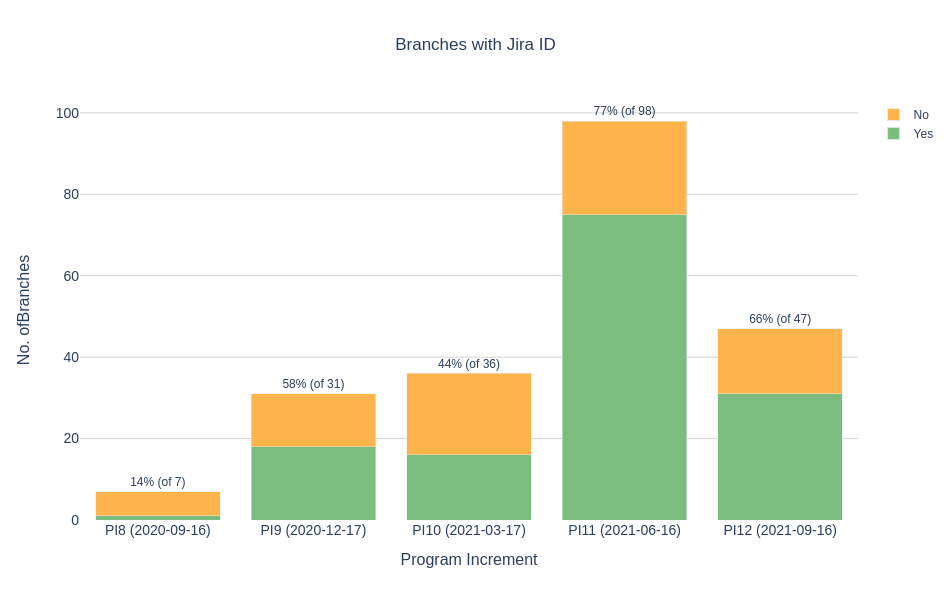

In [5]:
import plotly.graph_objects as go
stack_labels = ['{:.0f}% (of {:.0f})'.format(x, y) for x, y in zip(no_jira['percent'], no_jira['total'])]
fig = go.Figure(go.Bar(x=brs_jira.PI.unique(), y=brs_jira[brs_jira.jira == '1'].branch_id['count'], name='Yes',
    marker_color='#7ABD7E'))
fig.add_trace(go.Bar(x=brs_jira.PI.unique(), y=brs_jira[brs_jira.jira == '0'].branch_id['count'], name='No',
    marker_color='#FFB54C', text=stack_labels))
fig.update_xaxes(showgrid=False, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.update_traces(text=brs_jira.PI.unique(), textposition='outside')
fig.update_traces( textposition='outside')
fig.update_layout(barmode='stack', yaxis=dict(
        title='No. ofBranches',
        titlefont_size=16,
        tickfont_size=14,
    ), xaxis=dict(
        title='Program Increment',
        titlefont_size=16,
        tickfont_size=14,
    ), height=600, title='Branches with Jira ID', title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()


In [6]:

template_mr_trace = """

{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
"""

# output all the series in reverse order
query = []
tables = ", ".join([pi["pi"] for pi in pi_list])
for pi in pi_list:
#     pi["current_start"] = last_start
    query.append(template_mr_trace.format(pi))
query.append("""
union(tables: [{}])
  |> group()
  |> yield(name: "mrs")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()

mrs = query_api.query_data_frame(query)
# mrs = mrs[["_value", "_field"]]\
#     .rename(columns={"_value": "Merge Requests", "_field": "PI"})
mrs['ID'] = mrs['ID'].astype(int)
mrs['branch_jira'] = mrs['branch_jira'].astype(int)
mrs.sort_values(by=['ID', '_time'], ascending=[True, True], inplace=True)
mrs

result table                    _start                     _stop  \
20      mrs     0 2020-09-16 00:00:00+00:00 2020-12-16 23:59:59+00:00   
36      mrs     0 2020-09-16 00:00:00+00:00 2020-12-16 23:59:59+00:00   
70      mrs     0 2020-09-16 00:00:00+00:00 2020-12-16 23:59:59+00:00   
73      mrs     0 2020-09-16 00:00:00+00:00 2020-12-16 23:59:59+00:00   
74      mrs     0 2020-09-16 00:00:00+00:00 2020-12-16 23:59:59+00:00   
...     ...   ...                       ...                       ...   
3775    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
3777    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
3602    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
3575    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   
3836    mrs     0 2021-09-16 00:00:00+00:00 2021-12-16 23:59:59+00:00   

                                _time      _value           author  \
20   2020-09-16 07:07:15.651000+00:00  28924706.0  ElisabettaGiani   
36   2020-09-16 09:19:52.214000+00:00  37475900.0        HFRibeiro   
70   2020-09-16 09:34:04.427000+00:00  37474377.0           adb-42   
73   2020-09-16 09:43:18.551000+00:00  37471890.0           adb-42   
74   2020-09-16 10:21:22.683000+00:00  37469882.0           adb-42   
...                               ...         ...              ...   
3775 2021-11-23 23:10:20.633000+00:00     74128.0          keithbe   
3777 2021-11-23 23:39:19.624000+00:00      8586.0          keithbe   
3602 2021-11-24 01:23:15.705000+00:00      2399.0          damitch   
3575 2021-11-24 02:00:47.047000+00:00    160252.0       cnwangfeng   
3836 2021-11-24 02:08:31.265000+00:00    229490.0       luminosa42   

           authorname  branch_jira jira        merged_by      mr_id  \
20         Elisabetta            0    0  ElisabettaGiani   71031394   
36     Hélder Ribeiro            0    0        HFRibeiro   71043706   
70    Adriaan de Beer            1    0          unknown   71043796   
73    Adriaan de Beer            1    1           adb-42   71050320   
74    Adriaan de Beer            1    1           adb-42   71055412   
...               ...          ...  ...              ...        ...   
3775   Keith Bengston            1    1          keithbe  127343936   
3777   Keith Bengston            1    1          unknown  127562960   
3602  Daniel Mitchell            1    1          damitch  127567399   
3575        Feng Wang            1    1          unknown  127165023   
3836       Celeste Lu            1    1          unknown  127119139   

                            project project_id  \
20            ska-telescope/csp-lmc   15723860   
36         ska-telescope/ska-skampi   11448712   
70             ska-telescope/stupid   14654456   
73             ska-telescope/stupid   14654456   
74             ska-telescope/stupid   14654456   
...                             ...        ...   
3775      ska-telescope/ska-low-cbf   15856638   
3777      ska-telescope/ska-low-cbf   15856638   
3602    ska-telescope/ska-sdp-jacal   15942102   
3575  ska-telescope/external/rascil   19308749   
3836  ska-telescope/external/rascil   19308749   

                                            ref stale   state  ID  \
20                 fix-problem-integration-ADR8     0  merged   8   
36            webjive_suite-requirements-update     0  merged   8   
70                               st-473-license     0  closed   8   
73                                  st-473-test     0  merged   8   
74                                  st-473-test     0  merged   8   
...                                         ...   ...     ...  ..   
3775     at6-972-calculate-alveo-to-PST-routing     0  merged  12   
3777        at6-973-calculate-alveo-vct-entries     0  opened  12   
3602  yan-757-replicate_yandasoft_data_accessor     0  merged  12   
3575                ORC-1080-improve-imaging-qa     0  opened  12   
3836               orc-1005-update-skymodel-low     0  opened  12   

    

In [7]:
mrs_branch_jira = mrs[mrs.stale=='0'][['ID', 'PI','branch_jira','mr_id']].groupby(['ID', 'PI','branch_jira']).agg(['count', 'size', 'nunique']).reset_index()
mrs_branch_jira

ID                 PI branch_jira mr_id              
                                     count  size nunique
0   8   PI8 (2020-09-16)           0   158   158     158
1   8   PI8 (2020-09-16)           1   385   385     385
2   9   PI9 (2020-12-17)           0   259   259     259
3   9   PI9 (2020-12-17)           1   542   542     542
4  10  PI10 (2021-03-17)           0   129   129     129
5  10  PI10 (2021-03-17)           1   701   701     701
6  11  PI11 (2021-06-16)           0    84    84      84
7  11  PI11 (2021-06-16)           1  1014  1014    1014
8  12  PI12 (2021-09-16)           0    58    58      58
9  12  PI12 (2021-09-16)           1   914   914     914

In [8]:
mrs_branch_jira = mrs[mrs.stale=='0'][['ID', 'PI','branch_jira','mr_id']].groupby(['ID', 'PI','branch_jira']).agg(['count', 'size', 'nunique']).reset_index()
mrs_branch_jira = mrs_branch_jira.sort_values(by=['ID', 'branch_jira'], ascending=[True, False], inplace=False).reset_index()
no_jira = mrs[(mrs.stale=='0') & (mrs.branch_jira != 1)][['ID', 'PI','branch_jira','mr_id']].groupby(['ID', 'PI','branch_jira']).agg(['count', 'size', 'nunique']).reset_index()
no_jira = no_jira.sort_values(by=['ID', 'branch_jira'], ascending=[True, False], inplace=False).reset_index()
# no_jira['percent'] = (mrs_branch_jira.count / (mrs_branch_jira.count + no_jira.count))
# (mrs_branch_jira[mrs_branch_jira.branch_jira == 1].mr_id.reset_index() + 
#       mrs_branch_jira[mrs_branch_jira.branch_jira == 0].mr_id.reset_index()).mr_id

no_jira['total'] = (mrs_branch_jira.mr_id['count'] + no_jira.mr_id['count'])

no_jira['percent'] = (mrs_branch_jira[mrs_branch_jira.branch_jira == 1].reset_index().mr_id['count'] / 
     (mrs_branch_jira[mrs_branch_jira.branch_jira == 1].reset_index().mr_id['count'] + 
      mrs_branch_jira[mrs_branch_jira.branch_jira == 0].reset_index().mr_id['count'])) * 100
# mrs_branch_jira
no_jira


index  ID                 PI branch_jira mr_id               total  \
                                           count size nunique          
0     0   8   PI8 (2020-09-16)           0   158  158     158  543.0   
1     1   9   PI9 (2020-12-17)           0   259  259     259  417.0   
2     2  10  PI10 (2021-03-17)           0   129  129     129  671.0   
3     3  11  PI11 (2021-06-16)           0    84   84      84  343.0   
4     4  12  PI12 (2021-09-16)           0    58   58      58  759.0   

     percent  
              
0  70.902394  
1  67.665418  
2  84.457831  
3  92.349727  
4  94.032922

In [9]:
mrs[mrs.branch_jira == 0][['author', 'project', 'ref', 'stale', 'jira', 'branch_jira', 'ID']]

author                                        project  \
20    ElisabettaGiani                          ska-telescope/csp-lmc   
36          HFRibeiro                       ska-telescope/ska-skampi   
495         steve-ord             ska-telescope/ska-sdp-cbf-emulator   
441       robbarnsley       ska-telescope/sdc/sdc-submission-service   
445       robbarnsley       ska-telescope/sdc/sdc-submission-service   
...               ...                                            ...   
4218       saifulkhan           ska-telescope/sdp/ska-sdp-qa-display   
3478    andradazoltan  ska-telescope/ska-mid-cbf-engineering-console   
4238        steve-ord             ska-telescope/ska-sdp-cbf-emulator   
3758          jventer                   ska-telescope/ska-tango-base   
3522     atul.ghalame               ska-telescope/pss/ska-pss-rabbit   

                                            ref stale jira  branch_jira  ID  
20                 fix-problem-integration-ADR8     0    0            0   8  
36            webjive_suite-requirements-update     0    0            0   8  
495                   revert-the-python-changes     0    0            0   8  
441   add-auth-all-post-delete-update-endpoints     0    0            0   8  
445                                fix-dev-bind     0    0            0   8  
...                                         ...   ...  ...          ...  ..  
4218                        feature-spectrogram     0    1            0  12  
3478                                    develop     0    1            0  12  
4238                                hotfix/demo     0    0            0  12  
3758             sar_303-suggested-improvements     0    1            0  12  
3522                                        dev     0    1            0  12  

[702 rows x 7 columns]

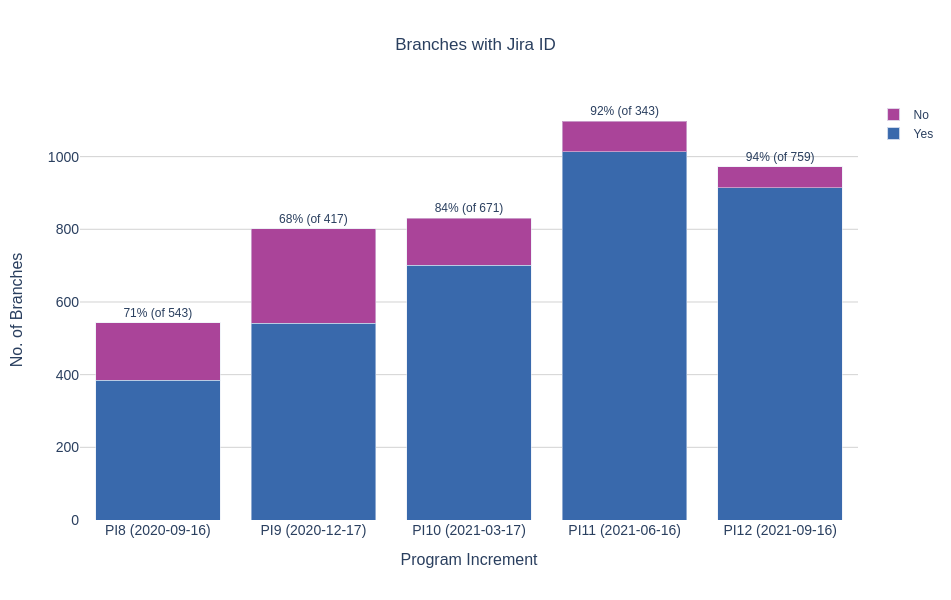

In [10]:
import plotly.graph_objects as go
stack_labels = ['{:.0f}% (of {:.0f})'.format(x, y) for x, y in zip(no_jira['percent'], no_jira['total'])]
fig = go.Figure(go.Bar(x=mrs_branch_jira.PI.unique(), y=mrs_branch_jira[mrs_branch_jira.branch_jira == 1].mr_id['count'], name='Yes',
    marker_color='rgb(57, 105, 172)'))
fig.add_trace(go.Bar(x=mrs_branch_jira.PI.unique(), y=mrs_branch_jira[mrs_branch_jira.branch_jira == 0].mr_id['count'], name='No',
    marker_color='rgb(170, 68, 153)', text=stack_labels))
fig.update_xaxes(showgrid=False, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.update_traces(text=mrs_branch_jira.PI.unique(), textposition='outside')
fig.update_traces( textposition='outside')
fig.update_layout(barmode='stack', yaxis=dict(
        title='No. of Branches',
        titlefont_size=16,
        tickfont_size=14,
    ), xaxis=dict(
        title='Program Increment',
        titlefont_size=16,
        tickfont_size=14,
    ), height=600, title='Branches with Jira ID', title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()
